# **Lab 1. Pruning**

## 0. Setup

In [ ]:
%pip install torchprofile 1>/dev/null

In [1]:
import copy
import math
import time
import random
import torch
import numpy as np

from collections import OrderedDict, defaultdict
from typing import Union, List
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from torchprofile import profile_macs
from tqdm.auto import tqdm

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support."

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
def download_url(url, model_dir='./model', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve

    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)

    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir

        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write(f'Downloading "{url}" to {cached_file}\n')
            urlretrieve(url, cached_file)
        
        return cached_file

    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, "download.lock"))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')

        return None


In [ ]:
class VGG11(nn.Module):
    cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

    def __init__(self):
        super().__init__()

        layers = []
        counts = defaultdict(int)

        def add(name: str, layer: nn.Module):
            layers.append((f"{name}{counts[name]}", layer))
            counts[name] += 1

        in_channels = 3
        for x in self.cfg:
            if x != 'M':
                add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
                add("bn", nn.BatchNorm2d(x))
                add("relu", nn.ReLU(True))
                in_channels = x

            else:
                add("pool", nn.MaxPool2d(2))

        self.backbone = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor):
        # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
        x = self.backbone(x)

        # avgpool: [N, 512, 2, 2] => [N, 512]
        x = x.mean([2, 3])

        # classifier: [N, 512] => [N, 10]
        x = self.classifier(x)

        return x

In [5]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    scheduler: LambdaLR,
    callbacks = None
):
    model.train()

    for inputs, labels in tqdm(dataloader, desc='train', leave=False):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Reset the gradients (from the last iteration)
        optimizer.zero_grad()

        # Forward inference
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward propagation
        loss.backward()

        # Update optimizer and LR scheduler
        optimizer.step()
        scheduler.step()

        if callbacks is not None:
            for callback in callbacks:
                callback()

In [6]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    verbose=True
):
    model.eval()

    num_samples = 0
    num_correct = 0

    for inputs, labels in tqdm(dataloader, desc='eval', leave=False, disable=not verbose):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Forward inference
        outputs = model(inputs)

        # Convert logits to class indices
        outputs = outputs.argmax(dim=1)

        # update metrics
        num_samples += labels.size(0)
        num_correct += (outputs == labels).sum()

        return (num_correct / num_samples * 100).item()

In [7]:
def get_model_macs(model: nn.Module, inputs: torch.Tensor):
    '''
        calculate MACs of the given model
    '''
    return profile_macs(model, inputs)

def get_sparsity(tensor: torch.Tensor):
    '''
        calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    '''
    return 1 - float(tensor.count_nonzero()) / tensor.numel()

def get_model_sparsity(model: nn.Module):
    '''
        calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    '''
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()

    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False):
    '''
        calculate the total number of parameters of model
        :param count_nonzero_only: only count nonzero weights
    '''
    num_counted_elements = 0

    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
        
    return num_counted_elements

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False):
    '''
        calculate the model size in bits
        :param data_width: #bits per element
        :param count_nonzero_only: only count nonzero weights
    '''
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [8]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([
        [-0.46, -0.40, 0.39, 0.19, 0.37],
        [0.00, 0.40, 0.17, -0.15, 0.16],
        [-0.20, -0.23, 0.36, 0.25, 0.03],
        [0.24, 0.41, 0.07, 0.13, -0.15],
        [0.48, -0.09, -0.36, 0.12, 0.45]
    ]),
    test_mask=torch.tensor([
        [True, True, False, False, False],
        [False, True, False, False, False],
        [False, False, False, False, False],
        [False, True, False, False, False],
        [True, False, False, False, True]
    ]),
    target_sparsity=0.75,
    target_nonzeros=None
):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item(): .2f}',
                               ha='center', va='center', color='k')
            
    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1, 2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')    
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')
    
    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

In [9]:
# load the pre-trained model and the CIFAR-10 dataset
ckpt_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
ckpt = torch.load(download_url(ckpt_url), map_location='cpu')

print(f"=> loading checkpoint '{ckpt_url}'")
model = VGG11().cuda()
model.load_state_dict(ckpt['state_dict'])

recover_model = lambda: model.load_state_dict(ckpt['state_dict'])

/tmp/ipykernel_69181/295204469.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(download_url(ckpt_url), map_location='cpu')


=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [10]:
img_size = 32

transforms = {
    "train": Compose([
        RandomCrop(img_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor()
    ]),
    "test": ToTensor()
}

dataset = {}
for split in ["train", "test"]:
    dataset[split] = CIFAR10(
        root='data/cifar10',
        train=(split == 'train'),
        download=True,
        transform=transforms[split]
    )

dataloader = {}
for split in ['train', 'test']:
    dataloader[split] = DataLoader(
        dataset[split],
        batch_size=512,
        shuffle=(split == 'train'),
        num_workers=0,
        pin_memory=True
    )

Files already downloaded and verified
Files already downloaded and verified


### Evaluate the accuracy and model size of dense model

In [11]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)

print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=93.36%
dense model has size=35.20 MiB


### Distribution of weight values

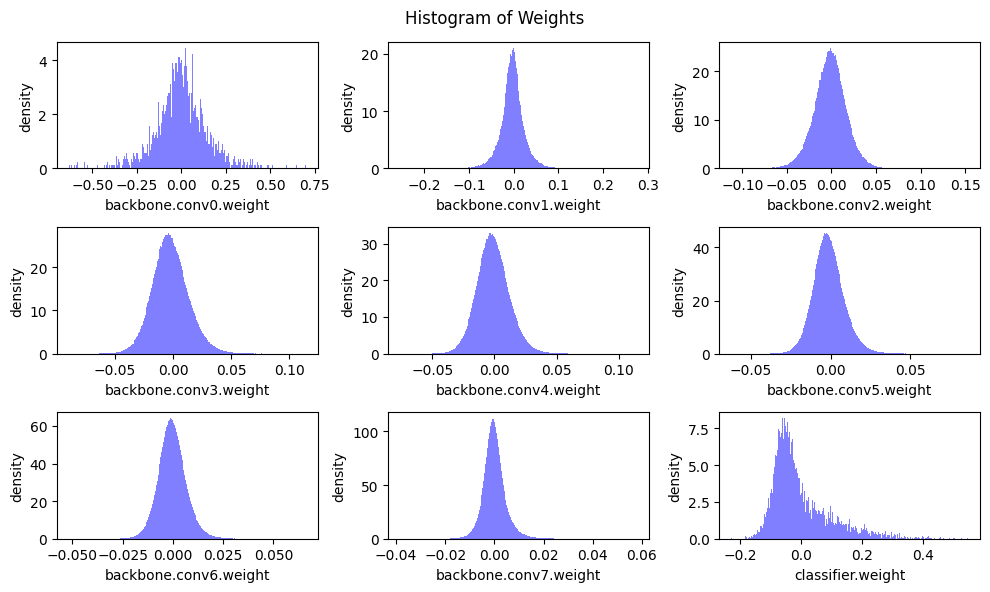

In [12]:
def plot_weight_distribution(model: nn.Module, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3, 3, figsize=(10, 6))
    axes = axes.ravel()
    plot_idx = 0

    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_idx]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                
                ax.hist(param_cpu, bins=bins, density=True,
                        color='blue', alpha=0.5)
            
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color='blue', alpha=0.5)
            
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            
            plot_idx += 1
    
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    
    plt.show()

plot_weight_distribution(model)

#### Question 1

Please answer the following questions using the information in the above histograms of weights.

* What are the common characteristics of the weight distribution in the different layers?

* How do these characteristics help pruning?

**Answer**

- 분포를 통해 공통적으로 확인할 수 있는 점은 전반적으로 모든 layer에서 0을 평균으로 하는 **Gaussian Distribution**을 따른다는 것입니다. 뿐만 아니라 x축 scale을 통해 확인할 수 있듯이 layer의 깊이가 깊어질수록 분산이 점점 좁아지는 것을 확인할 수 있습니다.

- 분산이 줄어든다는 것은 값이 0 근처에 값이 집중된다는 것을 의미합니다. 따라서, pruning 적용 시에 layer 깊이에 따라 점차 pruning ratio를 증가시켜 정확도 손실을 완화해줄 수 있습니다.

## 1. Fine-grained Pruning

Fine-grained pruning removes the synapses with lowest importance. The weight tensor $W$ will become sparse after fine-grained pruning, which can be described with **sparsity**:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

where $\#W$ is the number of elements in $W$.

In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.


### Magnitude-based Pruning

For fine-grained pruning, a widely-used importance is the magnitude of weight value, *i.e.*,

$Importance=|W|$

This is known as **Magnitude-based Pruning** (see [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)).

#### Question 2

Please complete the following magnitude-based fine-grained pruning function.

**Hint**

- step 1 \
we calculate the number of zeros (`num_zeros`) after pruning. Note that `num_zeros` should be an integer. You could use either `round()` or `int()` to convert a floating number into an integer. Here we use `round()`.    

- step 2 \
we calculate the `importance` of weight tensor. Pytorch provides [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) APIs.

- step 3 \
we calculate the pruning `threshold` so that all synapses with importance smaller than `threshold` will be removed. Pytorch provides [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) APIs.

- step 4 \
we calculate the pruning `mask` based on the `threshold`. **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. `mask = importance > threshold`. Pytorch provides [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) API.

In [13]:
def fine_grained_prune(tensor: torch.Tensor, sparsity: float):
    '''
        magnitude-based pruning for single tensor
        :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
        :param sparsity: float, pruning sparsity
            sparsity = #zeros / #elements = 1 - #nonzeros / #elements
        :return:
            torch.(cuda.)Tensor, mask for zeros
    '''
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    # 1. calculate the #zeros
    num_zeros = round(num_elements * sparsity)

    # 2. calculate the importance
    importance = torch.abs(tensor)

    # 3. calculate the pruning threshold
    threshold = importance.view(-1).kthvalue(num_zeros).values

    # 4. calculate the pruning mask
    mask = torch.gt(importance, threshold)

    # 5. apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

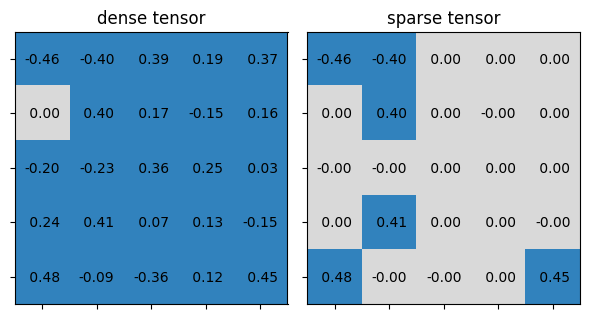

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [14]:
test_fine_grained_prune()

#### Question 3

The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.


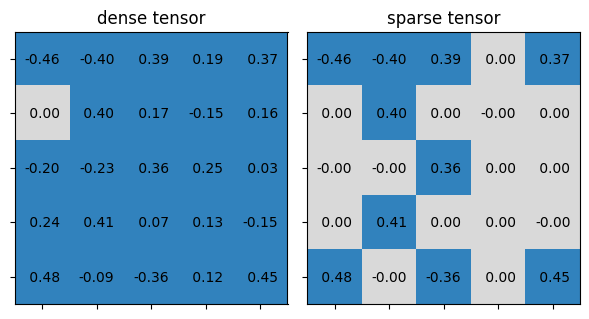

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [15]:
target_sparsity = 0.6
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class `FineGrainedPruner`, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

In [16]:
class FineGrainedPruner:
    def __init__(self, model: nn.Module, sparsity_dict: dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model: nn.Module):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]
        
    @staticmethod
    @torch.no_grad()
    def prune(model: nn.Module, sparsity_dict: dict):
        masks = dict()
        for name, param in model.named_parameters():
            # conv & fc layer의 weights만 pruning
            if param.dim() > 1:
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        
        return masks

### Sensitivity Scan

Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, **we will only prune one layer to see the accuracy degradation.** By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Figure 6 in [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf) is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (*i.e.*, sparsity). The y-axis is the validation accuracy.

In [17]:
@torch.no_grad()
def sensitivity_scan(
    model: nn.Module,
    dataloader: DataLoader,
    scan_step=0.1,
    scan_start=0.4,
    scan_end=1.0,
    verbose=True
):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [
        (name, param)
        for (name, param) in model.named_parameters()
        if param.dim() > 1
    ]

    for layer_i, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []

        for sparsity in tqdm(sparsities, desc=f'scanning {layer_i}/{len(named_conv_weights)} weight - {name}'):
            # 1. prune i-th layer's parameters
            fine_grained_prune(param.detach(), sparsity=sparsity)
            
            # 2. calculate the accuracy
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')

            # 3. restore the pruned parameters
            param.copy_(param_clone)
            accuracy.append(acc)

        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')

        accuracies.append(accuracy)
    
    return sparsities, accuracies

In [18]:
sparsities, accuracies = sensitivity_scan(model, dataloader['test'])

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.97%, 91.99%, 88.87%, 85.35%, 70.70%, 31.64%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.97%, 93.36%, 93.55%, 93.36%, 91.99%, 85.55%]

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[93.55%, 93.55%, 93.95%, 92.77%, 91.21%, 78.52%]

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[93.95%, 93.16%, 92.97%, 92.38%, 85.74%, 51.76%]

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[93.75%, 92.97%, 92.77%, 90.82%, 76.76%, 35.74%]

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[93.36%, 93.36%, 93.55%, 92.58%, 91.60%, 81.45%]

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.97%, 93.55%, 93.55%, 92.58%, 90.82%, 84.18%]

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[93.16%, 92.97%, 92.97%, 93.16%, 92.77%, 91.21%]

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[93.16%, 92.77%, 93.75%, 93.75%, 92.97%, 92.97%]

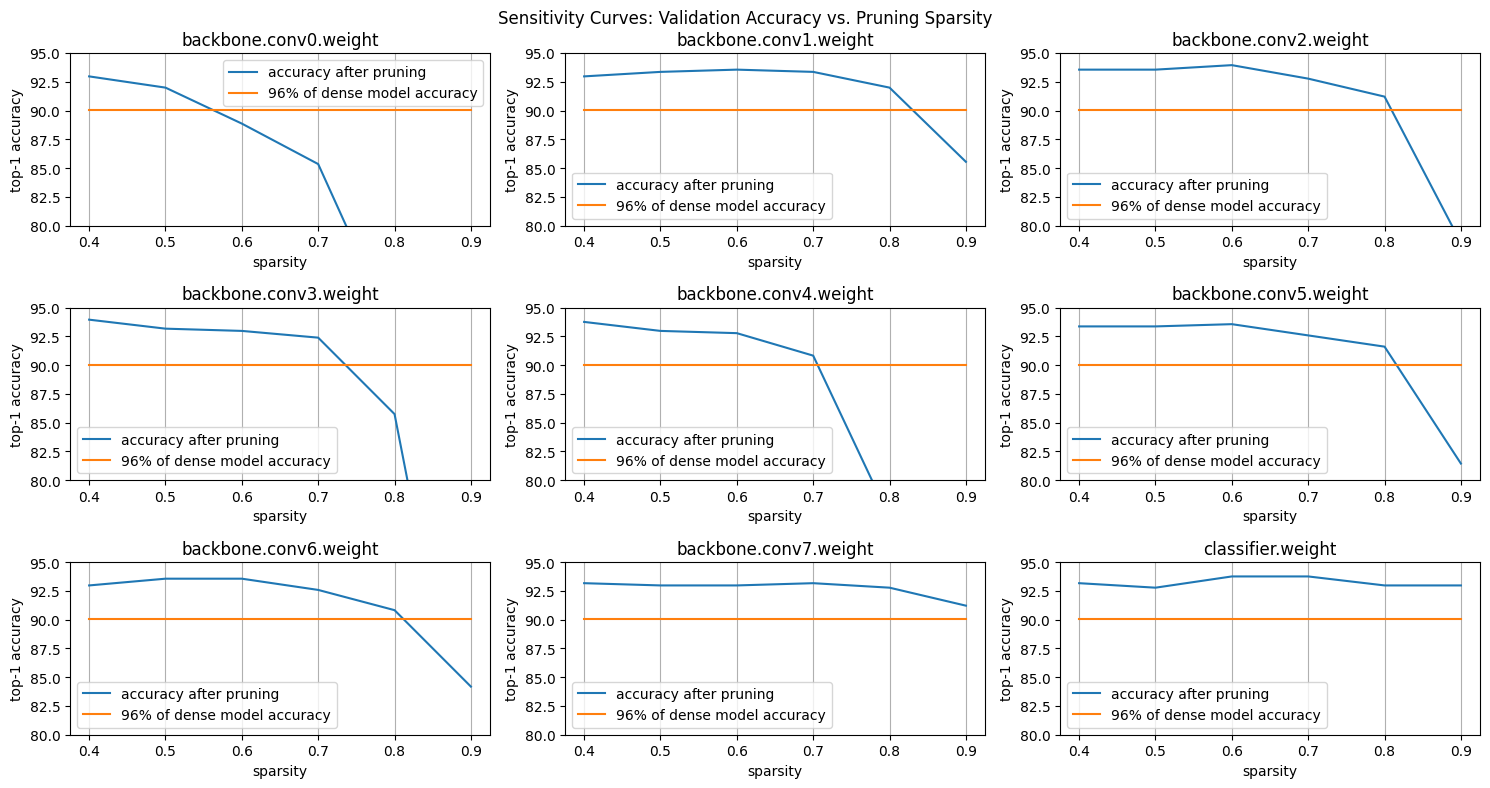

In [19]:
def plot_sparsity_scan(sparsities: list, accuracies: list, dense_model_accuracy: float):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5

    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)), figsize=(15, 8))
    axes = axes.ravel()

    plot_idx = 0
    for name, param in model.named_parameters():
        if param.dim() <= 1: continue

        ax = axes[plot_idx]
        curve = ax.plot(sparsities, accuracies[plot_idx])
        line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))

        ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
        ax.set_ylim(80, 95)
        
        ax.set_title(name)
        ax.set_xlabel('sparsity')
        ax.set_ylabel('top-1 accuracy')
        
        ax.legend([
            'accuracy after pruning',
            f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
        ])
        ax.grid(axis='x')

        plot_idx += 1
    
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    
    plt.show()

plot_sparsity_scan(sparsities, accuracies, dense_model_accuracy)

#### Question 4

Please answer the following questions using the information in the above sensitivity curves.

- What's the relationship between pruning sparsity and model accuracy? (*i.e.*, does accuracy increase or decrease when sparsity becomes higher?)

- Do all the layers have the same sensitivity?

- Which layer is the most sensitive to the pruning sparsity?


**Answer**

- 모든 그래프의 경향성을 확인해보면 x축의 sparsity ratio가 높아질수록 y축의 accuracy가 감소하는 것을 확인할 수 있습니다.
- 다만, 각 convolution layer마다 정확도가 급격하게 하락하는 지점이 다릅니다. 즉, 각 layer마다 네트워크의 성능에 미치는 영향이 다르다는 것을 의미하고 이는 곧 민감도가 다르다는 것을 의미합니다.
- `conv0` layer가 다른 layer에 비해 훨씬 작은 pruning ratio 0.6 근처에서 기존 모델의 정확도보다 낮은 정확도를 보이기 때문에 가장 민감도가 높은 layer입니다. 반대로 `classifier`의 경우, 민감도가 가장 낮아 pruning ratio 0.9라도 정확도에 큰 변화가 없는 것을 확인할 수 있습니다.

### #Parameters

In addition to accuracy, the number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parameters require larger sparsities.

Please run the following code cell to plot the distribution of #parameters in the whole model.

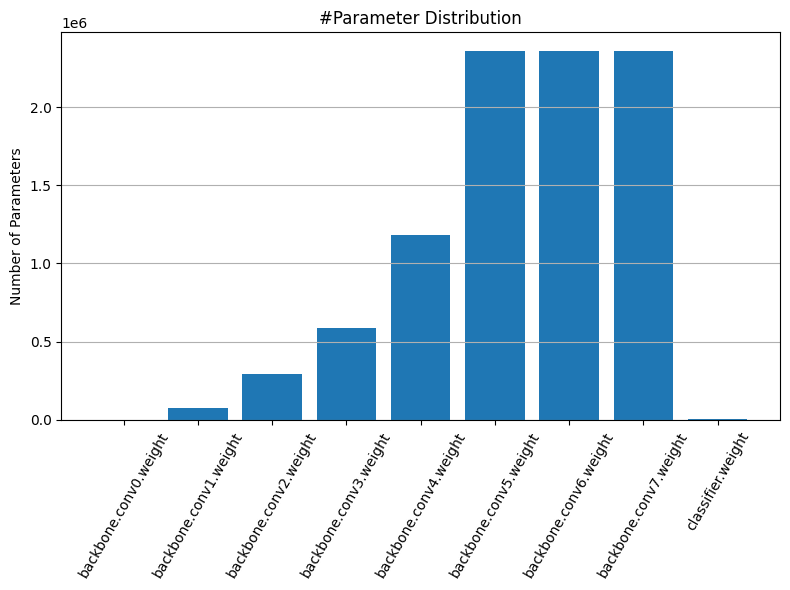

In [20]:
def plot_num_parameters_distribution(model: nn.Module):
    num_parameters = dict()

    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()

    fig = plt.figure(figsize=(8, 6))
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))

    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)

    plt.grid(axis='y')
    plt.tight_layout()

    plt.show()

plot_num_parameters_distribution(model)

### Select Sparsity

#### Question 5

Based on the sensitivity curves and the distribution of #parameters in the model, please select the sparsity for each layer.

Note that the overall compression ratio of pruned model mostly depends on the layers with larger #parameters, and different layers have different sensitivity to pruning (see Question 4).

Please make sure that after pruning, the sparse model is 25% of the size of the dense model, and validation accuracy is higher than 92.5 **after finetuning.**

**Hint**:
*   The layer with more #parameters should have larger sparsity. (see *Figure #Parameter Distribution*)
*   The layer that is sensitive to the pruning sparsity (i.e., the accuracy will drop quickly as sparsity becomes higher) should have smaller sparsity. (see *Figure Sensitivity Curves*)

In [21]:
recover_model()

sparsity_dict = {
    'backbone.conv0.weight': 0.5,
    'backbone.conv1.weight': 0.8,
    'backbone.conv2.weight': 0.8,
    'backbone.conv3.weight': 0.7,
    'backbone.conv4.weight': 0.7,
    'backbone.conv5.weight': 0.8,
    'backbone.conv6.weight': 0.8,
    'backbone.conv7.weight': 0.9,
    'classifier.weight': 0.9
}

After pruning with sparsity dictionary
  backbone.conv0.weight: 0.50
  backbone.conv1.weight: 0.80
  backbone.conv2.weight: 0.80
  backbone.conv3.weight: 0.70
  backbone.conv4.weight: 0.70
  backbone.conv5.weight: 0.80
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.90
  classifier.weight: 0.90
The sparsity of each layer becomes
  backbone.conv0.weight: 0.50
  backbone.conv1.weight: 0.80
  backbone.conv2.weight: 0.80
  backbone.conv3.weight: 0.70
  backbone.conv4.weight: 0.70
  backbone.conv5.weight: 0.80
  backbone.conv6.weight: 0.80
  backbone.conv7.weight: 0.90
  classifier.weight: 0.90
Sparse model has size=6.83 MiB = 19.41% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=65.62% before fintuning


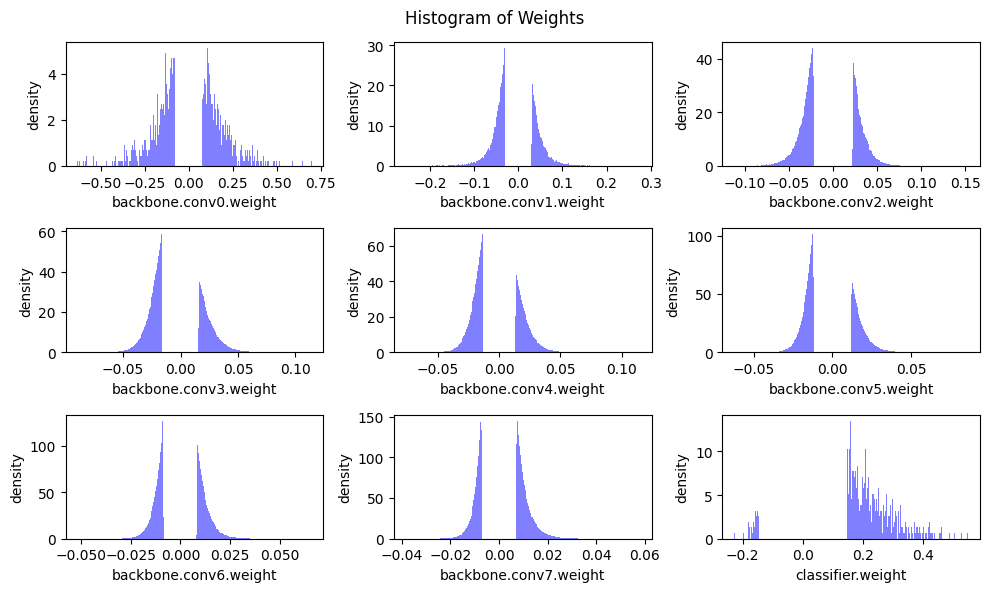

In [22]:
pruner = FineGrainedPruner(model, sparsity_dict)

print('After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')

print('The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

### Finetune the fine-grained pruned model

As we can see from the outputs of previous cell, even though fine-grained pruning reduces the most of model weights, the accuracy of model also dropped. Therefore, we have to finetune the sparse model to recover the accuracy.

Please run the following cell to finetune the sparse model. It should take around 3 minutes to finish.

In [23]:
num_finetune_epochs = 5

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0

print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # pruning 된 부분의 weight를 변경시키지 않기 위해 apply를 매 학습 종료 후 적용
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    
    # 최고 성능의 모델만 저장
    accuracy = evaluate(model, dataloader['test'])
    if accuracy > best_accuracy:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')    

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 92.77% / Best Accuracy: 92.77%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.77% / Best Accuracy: 92.77%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 93.75% / Best Accuracy: 93.75%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 93.75% / Best Accuracy: 93.75%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 93.75% / Best Accuracy: 93.75%


In [24]:
# evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=6.83 MiB = 19.41% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=93.75% after fintuning


In [25]:
# save the final model
torch.save(model.state_dict(), './model/fine_grained_vgg.pth')

## 2. Channel Pruning

Channel pruning removes an entire channel, so that it can achieve inference speed up on existing hardware like GPUs. Similarly, we remove the channels whose weights are of smaller magnitudes (measured by Frobenius norm).

In [38]:
recover_model()

dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=93.36%


### Remove Channel Weights

Unlike fine-grained pruning, we can remove the weights entirely from the tensor in channel pruning. That is to say, the number of output channels is reduced:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

The weight tensor $W$ is still dense after channel pruning. Thus, we will refer to *sparsity* as ***prune ratio***.

Like fine-grained pruning, we can use different pruning rates for different layers. However, we use a uniform pruning rate for all the layers for now. We are targeting 2x computation reduction, which is roughly 30% uniform pruning rate.

Feel free to try out different pruning ratios per layer at the end of this section. You can pass in a list of ratios to the `channel_prune` function.

#### Question 6

Please complete the following functions for channel pruning.

Here we naively prune all output channels other than the first $\#\mathrm{out\_channels}_{\mathrm{new}}$ channels.

In [27]:
def get_num_channels_to_keep(channels: int, prune_ratio: float):
    '''
        A function to calculate the number of layers to PRESERVE after pruning
        Note that preserve_rate = 1. - prune_ratio 
    '''
    return int(round(channels * (1. - prune_ratio)))

@torch.no_grad()
def channel_prune(model: nn.Module, prune_ratio: Union[List, float]):
    '''
        Apply channel pruning to each of the conv layer in the backbone
        Note that for prune_ratio, we can either provide a floating-point number,
        indicating that we use a uniform pruning rate for all layers, or a list of
        numbers to indicate per-layer pruning rate.
    '''
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))

    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:
        prune_ratio = [prune_ratio] * (n_conv - 1)
    
    # prevent overwrite
    model = copy.deepcopy(model)

    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    assert len(all_convs) == len(all_bns)

    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv, prev_bn = all_convs[i_ratio], all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]

        # calculate the number of channels to keep
        original_channels = prev_conv.out_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of next conv
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
    
    return model


In [28]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()

pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)

assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

* Check passed. Right MACs for the pruned model.


In [29]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f'pruned model has accurac={pruned_model_accuracy: .2f}%')

eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accurac= 26.56%


### Ranking Channels by Importance

As you can see, removing the first 30% of channels in all layers leads to significant accuracy reduction. One potential method to remedy the issue is to find the **less important** channel weights to remove. A popular criterion for importance is to use the Frobenius norm of the weights corresponding to each input channel:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

We can sort the channel weights from more important to less important, and then keep the frst $k$ channels for each layer.


#### Question 7

Please complete the following functions for sorting the weight tensor based on the Frobenius norm.

**Hint**:
* To calculate Frobenius norm of a tensor, Pytorch provides [`torch.norm`](https://pytorch.org/docs/master/generated/torch.norm.html?highlight=torch+norm#torch.norm) APIs.

In [39]:
def get_input_channel_importance(weight):
    '''
        sort the channels from important to non-important
    '''
    in_channels = weight.shape[1]
    
    # compute the importance for input channel
    importances = []
    for i_c in range(in_channels):
        channel_weight = weight.detach()[:, i_c]
        importance = torch.norm(channel_weight)
        importances.append(importance.view(1))
    
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model: nn.Module):
    '''
        each channel sorting index, we need to apply it to:
        - the output dimension of the previous conv
        - the previous BN layer
        - the input dimension of the next conv (we compute importance here)
    '''
    # prevent overwriting
    model = copy.deepcopy(model)

    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]

    for i_conv in range(len(all_convs) - 1):
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]

        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)

        # sort from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx
        ))
        for name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, name)
            tensor_to_apply.copy_(torch.index_select(
                tensor_to_apply.detach(), 0, sort_idx
            ))
        
        # apply to the next conv input
        next_conv.weight.copy_(torch.index_select(
            next_conv.weight.detach(), 1, sort_idx
        ))

    return model    

In [40]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting
# since it is equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=93.36%
After sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

sorted model has accuracy=93.36%
* Check passed.


In [41]:
channel_pruning_ratio = 0.3

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=26.56%
 * With sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=39.06%


As you can see, the channel sorting can slightly improve the pruned model's accuracy, but there is still a huge degrade, which is quite common for channel pruning. But luckily, we can perform fine-tuning to recover the accuracy.

In [42]:
num_finetune_epochs = 5

optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    
    accuracy = evaluate(pruned_model, dataloader['test'])
    if accuracy > best_accuracy:
        best_accuracy = accuracy
    
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')    

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 92.19% / Best Accuracy: 92.19%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.77% / Best Accuracy: 92.77%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 93.16% / Best Accuracy: 93.16%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.97% / Best Accuracy: 93.16%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 93.36% / Best Accuracy: 93.36%


### Measure acceleration from pruning

After fine-tuning, the model almost recovers the accuracy. You may have already learned that channel pruning is usually more difficult to recover accuracy compared to fine-grained pruning. However, it directly leads to a smaller model size and smaller computation without specialized model format. It can also run faster on GPUs. Now we compare the model size, computation, and latency of the pruned model.

In [44]:
@torch.no_grad
def measure_latency(model: nn.Module, dummy_input: torch.Tensor, n_warmup=20, n_test=100):
    '''
        helper functions to measure latency of a regular PyTorch models.
        Unlike fine-grained pruning, channel pruning can directly leads to model size reduction and speed up.
    '''
    model.eval()

    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)

    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()

    return (t2 - t1) / n_test

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# measure on CPU to simulate inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
model = model.to('cpu')
pruned_model = pruned_model.to('cpu')

# measure the latency
original_latency = measure_latency(model, dummy_input)
pruned_latency = measure_latency(pruned_model, dummy_input)
print(table_template.format(
    'Latency (ms)',
    round(original_latency * 1000, 1),
    round(pruned_latency * 1000, 1),
    round(original_latency / pruned_latency, 1)
))

# measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format(
    'MACs (M)',
    round(original_macs / 1e6),
    round(pruned_macs / 1e6),
    round(original_macs / pruned_macs, 1)
))

# measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format(
    'Param (M)',
    round(original_param / 1e6, 2),
    round(pruned_param / 1e6, 2),
    round(original_param / pruned_param, 1)
))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    5.6             3.5             1.6            
MACs (M)        606             305             2.0            
Param (M)       9.23            5.01            1.8            


#### Question 8

Please answer the following questions using the information in the previous code cell.

- Explain why removing 30% of channels roughly leads to 50% computation reduction.

- Explain why the latency reduction ratio is slightly smaller than computation reduction.

**Answer**

- convolution 연산에서 #MACs는 다음과 같이 계산할 수 있습니다.
    > $$
    > \begin{align}
    > \text{computation}_{\text{ori}} &= C_{\text{in}} \times C_{\text{out}} \times K \times H \times W \\
    > \text{computation}_{\text{new}} &= (C_{\text{in}} \times 0.7) \times (C_{\text{out}} \times 0.7) \times K \times H \times W \\
    > &= 0.49 \times \text{computation}_{\text{ori}} \\
    > &\approx 0.5 \times \text{computation}_{\text{ori}}
    > \end{align}
    > $$

    즉, in_channels와 out_channels가 각각 기존의 70%만 존재하기 때문에, 0.49로 대략 50%의 계산량 감소를 기대할 수 있습니다.

- latency는 convolution 연산으로 인한 계산뿐 아니라 다양한 요소가 관여합니다.
    - memory access overhead \
        실험 결과를 통해서도 확인할 수 있듯이, 파라미터 수는 절반으로 감소하지 않았기 때문에 데이터 로딩 및 메모리 접근으로 인한 오버헤드는 절반이 되지 않습니다.
    - non-convolution layers \
        convolution layer의 경우 $C_{\text{in}}^2$ 에 비례하여 계산량이 감소하는 반면, BatchNorm이나 ReLU 같은 연산은 $C_{\text{in}}$ 에 비례하기 때문에 계산량 또한 정확히 절반으로 볼 수 없습니다.
    - system overhead \
        함수 호출, 커널 실행 등 시스템 레벨에서 발생하는 오버헤드는 pruning과 무관하게 항상 발생하게 됩니다.

## 3. Compare Fine-grained Pruning and Channel Pruning

#### Question 9

After all experiments in this lab, you may have become familiar with both fine-grained pruning and channel pruning.

Please answer the following questions using what you have learned from the lectures and this lab.

- What are the advantages and disadvantages of fine-grained pruning and channel pruning? You can discuss from the perspective of compression ratio, accuracy, latency, hardware support (*i.e.*, requiring specialized hardware accelerator), etc.

- If you want to make your model run faster on a smartphone, which pruning method will you use? Why?


**Answer**

- 두 pruning 방식의 가장 큰 차이점은 structured vs. unstructured pruning 여부입니다. Fine-grained pruning은 일정한 패턴 없이 개별 파라미터를 제거하는 반면, channel pruning은 특정 채널 전체를 구조적으로 제거합니다.

    - fine-grained pruning
        - *compression ratio & accuracy* \
        element-wise로 중요하지 않은 파라미터를 제거할 수 있어 channel pruning에 비해 높은 압축률을 가져갈 수 있습니다. 이는 다시 말하면, 동일한 pruning ratio 에서 더 나은 성능을 보인다는 것을 의미합니다. 실제로 fine-tuning 전후 모두 fine-grained pruning이 더욱 높은 정확도를 보인다는 것을 확인할 수 있었습니다.

        - *latency & hardware support* \
        일정한 패턴이 없기 때문에 sparse matrix의 불규칙적인 메모리 접근으로 인한 오버헤드가 발생하고 이는 곧 latency를 높이게 됩니다. 이러한 문제를 해결하기 위해서는 하드웨어에서 지원하는 별도의 sparse 가속기를 필요로 합니다.
    
    - channel pruning
        - *compression ratio & accuracy* \
        channel pruning은 특정 channel 전체를 제거하는 과정에서 중요한 파라미터가 없어질 수 있기 때문에 소극적으로 제거할 수 밖에 없고 이는 압축률을 떨어뜨리게 됩니다. 즉, fine-grained 대비 동일한 pruning ratio 에서 더 낮은 성능을 보입니다.

        - *latency & hardware support* \
        pruning 이후에도 dense matrix 를 유지하기 때문에 **별도의 하드웨어 지원 없이도** 연속적인 메모리 접근으로 낮은 latency를 가져 fine-grained 대비 빠른 추론 속도를 누릴 수 있습니다.

- channel pruning을 사용하는 것이 효과적일 것입니다.

    스마트폰 환경에서 무엇보다 중요한 점은 **latency** 입니다. 물론, sparse matrix 연산에 최적화된 하드웨어 가속을 지원하는 경우, fine-grained pruning을 사용하는 것이 효과적이겠지만, 대부분의 스마트폰 프로세서의 경우 이를 지원하지 않습니다. \
    따라서, channel-pruning과 같은 structured pruning을 사용하는 것이 별도의 하드웨어 지원 없이 빠른 추론 속도를 가져갈 수 있어 더욱 실용적일 것입니다.